# 합성곱 신경망 (CNN)
- 이미지 인식, 음성 인식 등 다양한 곳에서 사용

합성곱 계층 , 풀링 계층

신경망 - 인접하는 계층의 모든 뉴런과 결합 (완전 연결)
완전히 연결된 계층 (Afiine 계층)

<완전연결 계층 Affine계층으로 이뤄진 네트워크>
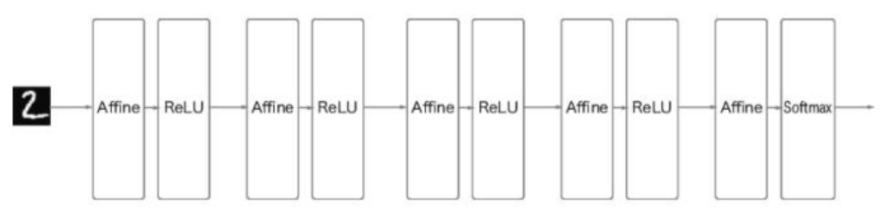

- 완전연결 신경망 : Affine 계층 뒤에 활성화 함수를 갖는 ReLU 계층(혹은 Sigmoid)
- 마지막은 Softmax 계층에서 최종 결과 출력

<CNN으로 이뤄진 네트워크 - 합성곱 계층/풀링 계층 추가>
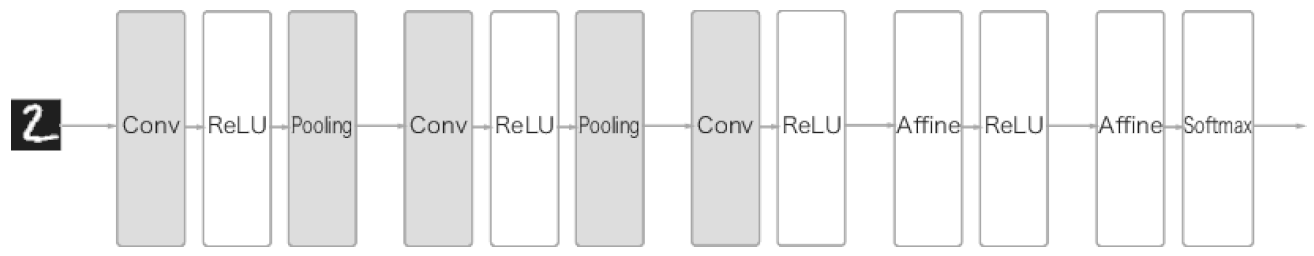

## 7.2 합성곱 계층

- 1) 완전연결 계층 - 인접하는 계층의 뉴런이 모두 연결되고 출력의 수는 임의로 정할 수 있다.
	문제점 : 데이터의 형상이 무시     이미지 (3차원) →1차원 데이터로 평탄화 1줄로 세운 784개 데이터 를 Affine 계층에 입력

합성곱 = 형상 유지, 이미지 3차원 → 다음 계층에도 3차원 데이터로 전달

입력 데이터 (입력 특징 맵)	출력 데이터 (출력 특징 맵)  


- 2) 합성곱 연산 (이미지 처리의 ‘필터연산’)
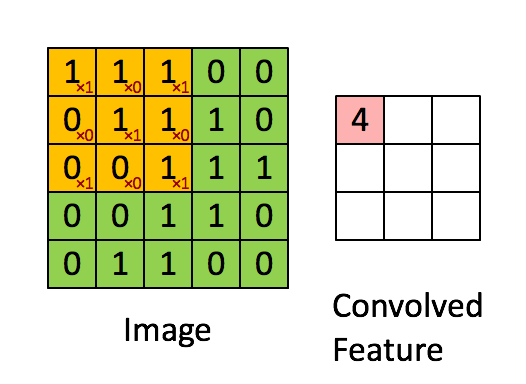
입력데이터(입력특징맵) * 필터 = (  ) + 편향 →  출력데이터(출력특징맵)

- 3) 패딩  - 크기 유지
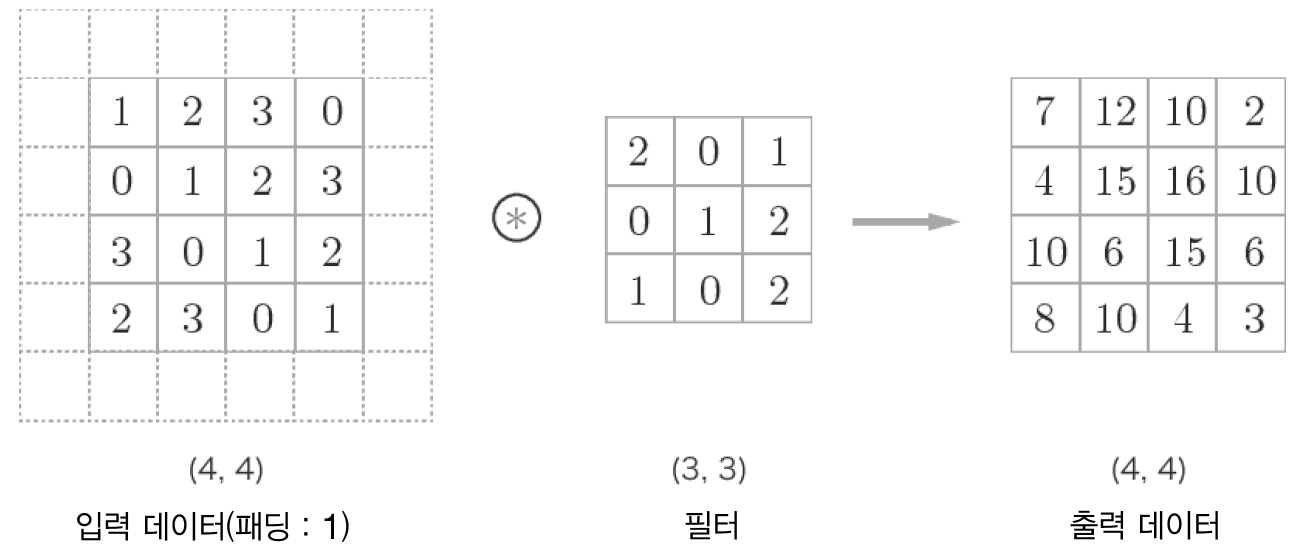
(4,4) → (6,6) * 필터 = (4,4)유지

- 4) 스트라이드
    - 필터 적용 위치 간격 (윈도우 칸 이동 수)
    - 스트라이드 ↑, 출력 크기 ↓
    = 패딩 ↑, 출력 크기↑  
    

     - 입력크기 (H,W)	필터 크기(FH,HW)	출력크기(OH,OW) 	패딩 P		스트라이드S
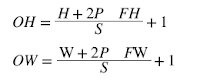

- 5) 드디어 3차원!! - 길이방향(채널방향) 특징 맵 늘어남
입력데이터 채널수 = 필터의 채널  
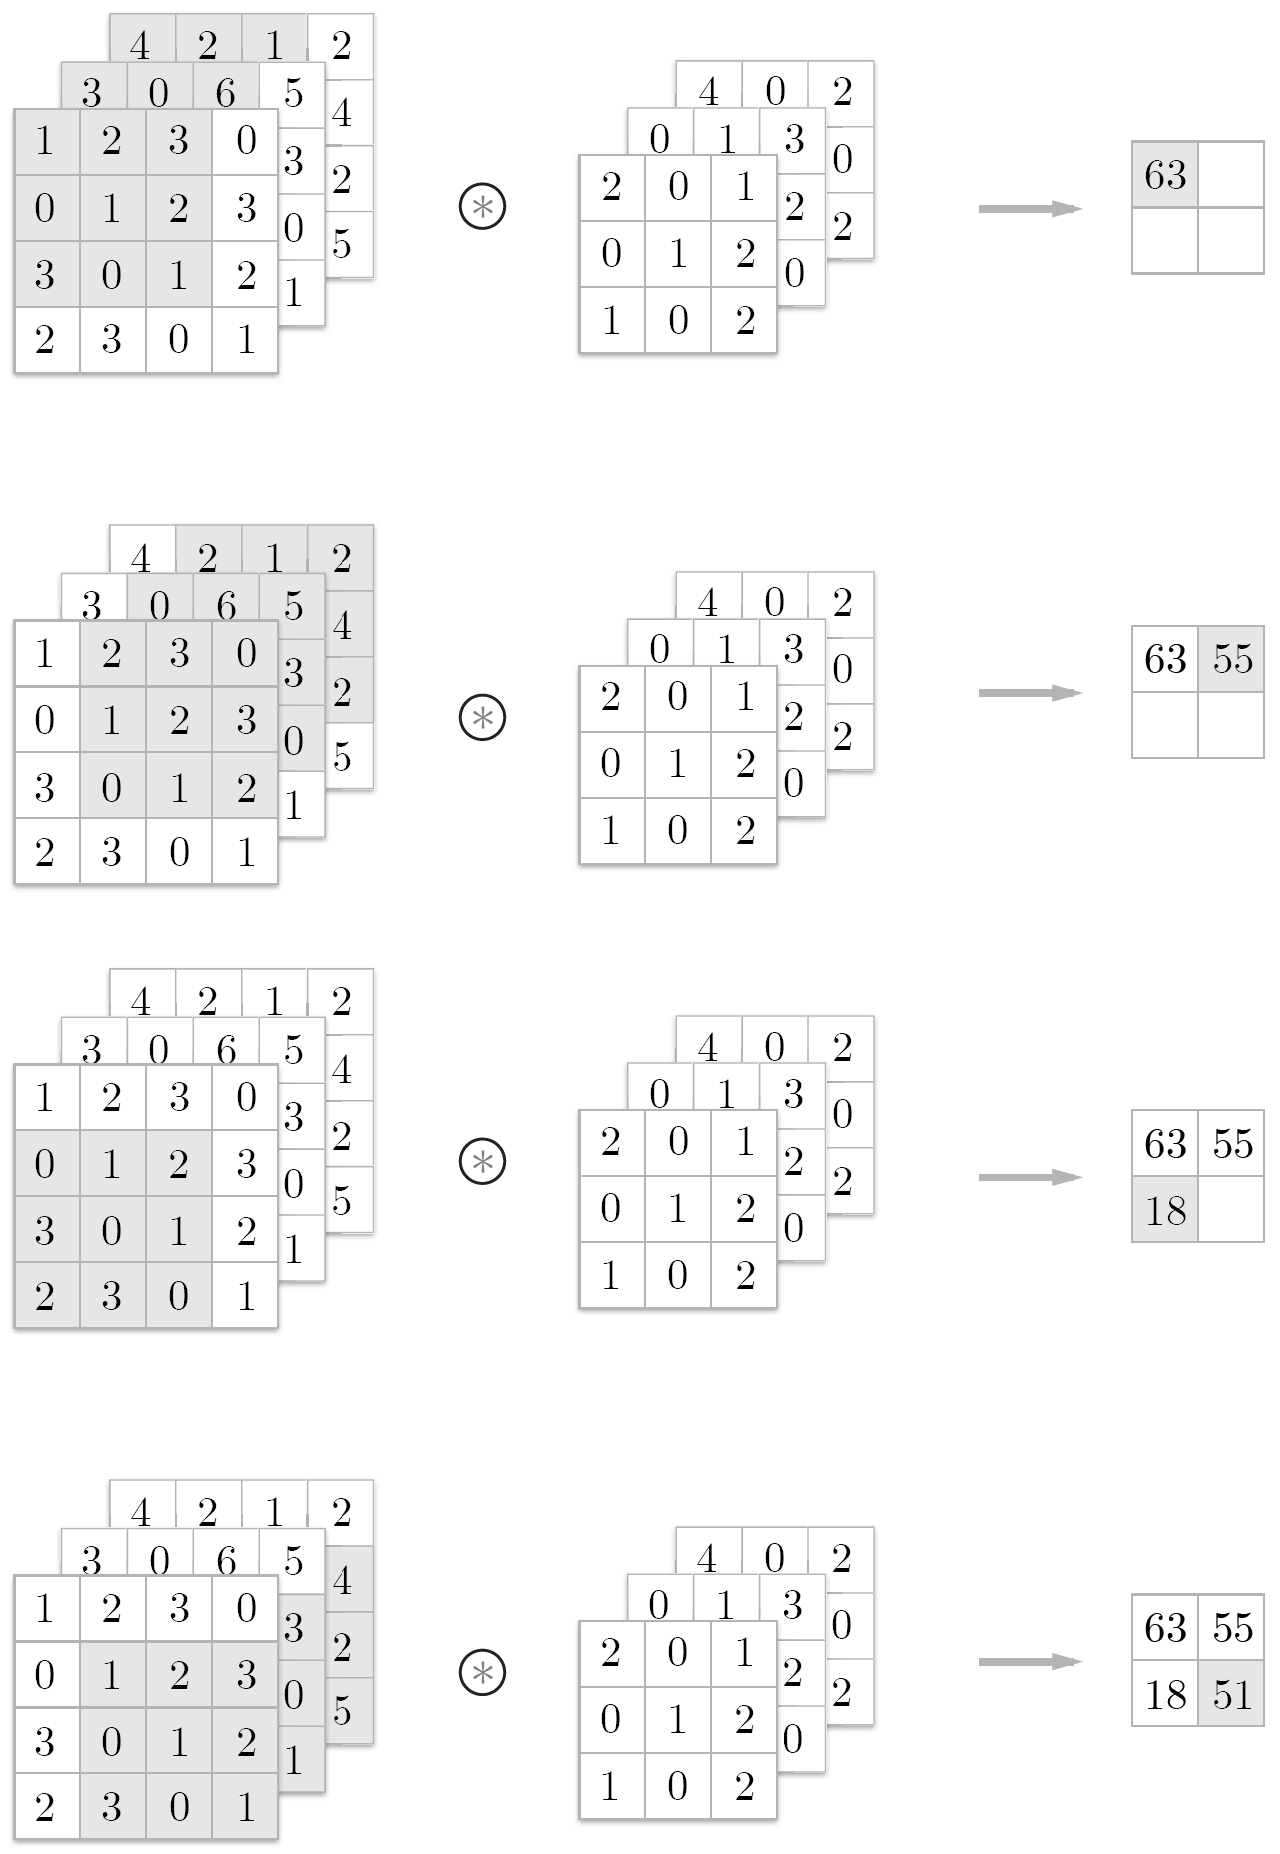  
---

3차원 합성곱 = 직육면체 블록 (채널, 높이, 너비) = (C,H,W) * (C,FH,FW) => (1,OH,OW)

필터를 여러개 → 출력 데이터 채널 ↑  
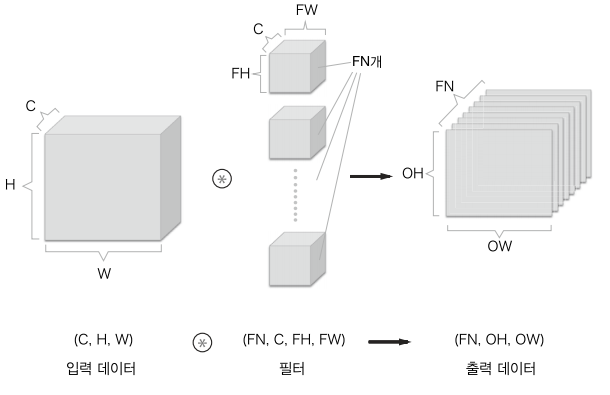  
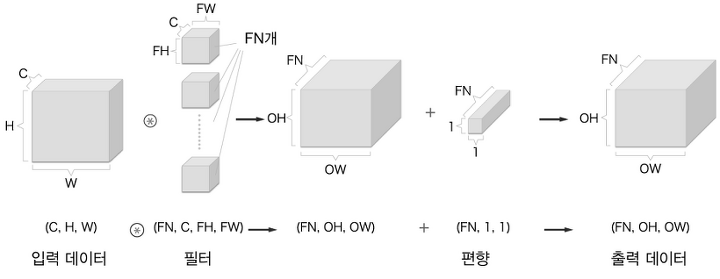  
편향 - 채널 하나 하나 씩 구성   

7) 배치 처리 - 입력 데이터를 한 덩어리로 묶어 배치로 처리
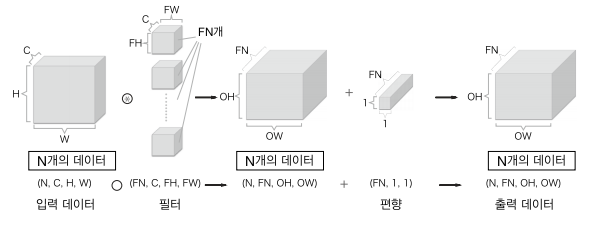
(데이터 수,  채널 수, 높이, 너비)  

7-3 풀링 계층 – 세로, 가로 방향의 공간을 줄이는 연산
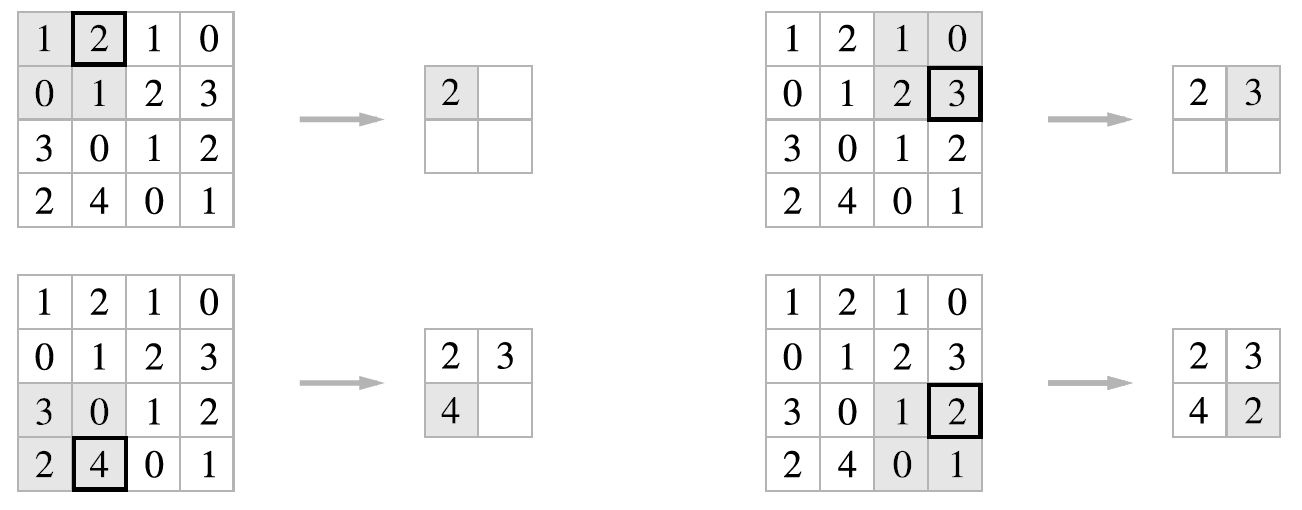

<2 X 2 최대 풀링 Max pooling> : 스트라이드 2로 처리 , 2 X 2영역에서 가장 큰 원소 꺼내기 → 최댓값을 구하는 연산 

특징 
- 1) 학습해야 할 매개변수가 없다.    -앞에꺼와 상관없이 독립적이다.
- 2) 채널 수가 변하지 않는다.    - 입력데이터 채널 수 그대로 출력데이터로 보낸다.
- 3) 입력 변화에 영향을 적게 받는다. (강건하다) - 

# 7.4 합성곱/풀링 계층구현하기
## 4차원 배열

In [ ]:
import numpy as np

In [3]:
x=np.random.rand(10,1,28,28)
x.shape

(10, 1, 28, 28)

CNN 데이터 : 4차원 - 높이 28, 너비 28, 채널 1개인 데이터가 10개  

In [6]:
x[0].shape   # 10개의 데이터 중 1번째 데이터
x[1].shape   # 10개의 데이터 중 2번째 데이터

(1, 28, 28)

In [ ]:
x[0,0]    # 1번째 데이터의 채널 1 
x[0][0]

## im2col 함수를 이용하여 데이터 전개하기  (image to column)
- 입력 데이터를 필터링(가중치 계산) 하기 좋게 펼치는 함수  
    - 배치 포함 4차원 데이터 --> 2차원 행렬
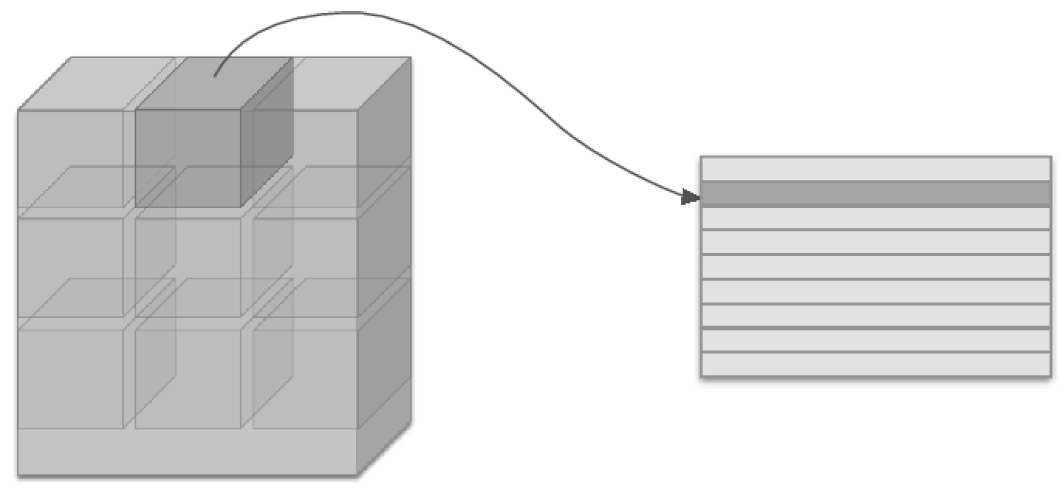
- 필터 적용 영역 겹치면 전개 후, 원소 수가 많아짐(메모리 소비 단점)  
- 큰 행렬 곱셈 계산은 컴퓨터가 빠르게 처리 가능

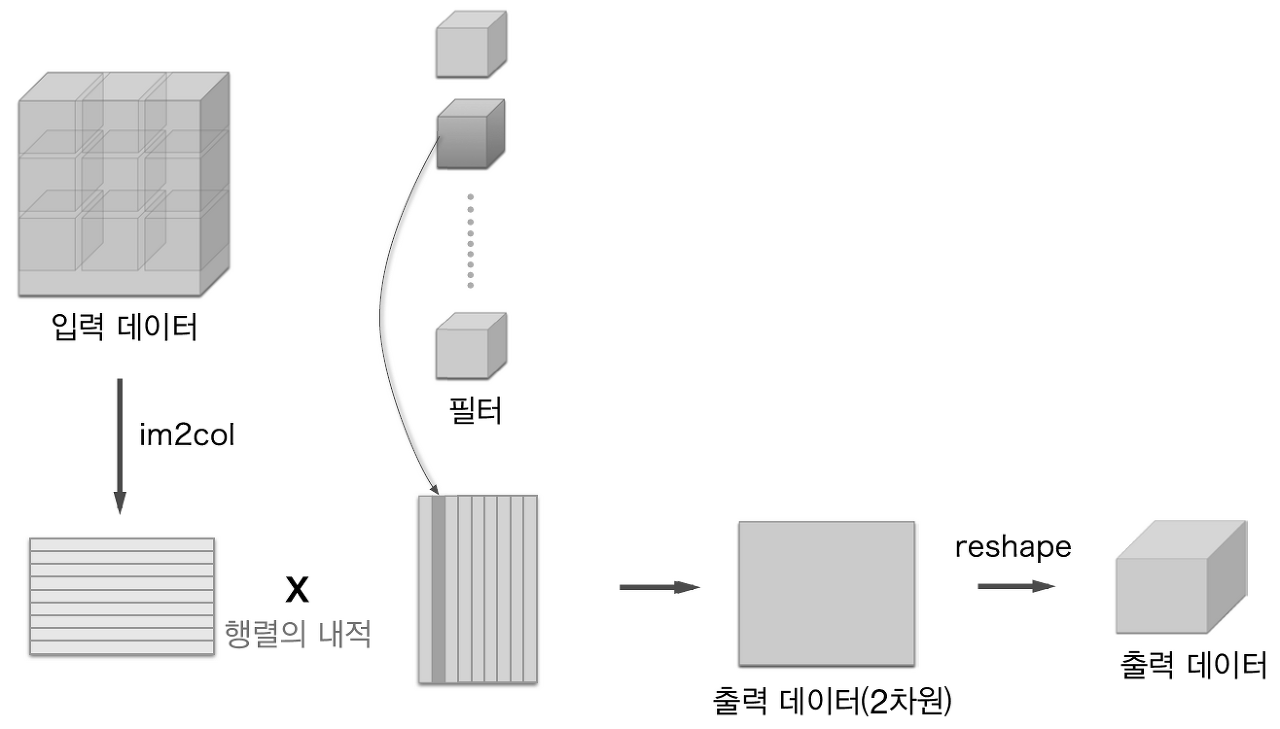  
    
### 4차원 입력데이터 전개 -> 필터 세로 1열 전개 -> 행렬 내적 계산 (2차원) -> 4차원 출력 데이터 reshape  
[완전연결  계층_Affine계층 과 비슷]  
  
    
## 합성곱 계층 구현하기

In [12]:
# im2col함수 - 필터 크기, 스트라이드, 패딩 을 고려하여 입력 데이터 -> 2차원 배열로 전개

def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [14]:
#im2col 함수 이용 예시
import sys, os
sys.path.append(os.pardir)
#from common.util import im2col

x1 = np.random.rand(1,3,7,7)             # 배치 크기(데이터)1개, 채널 3개, 7X7 데이터
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)           #(9, 75)  #75 = 필터의 원소수? p245

x2 = np.random.rand(10,3,7,7)             # 배치 크기(데이터)10개, 채널 3개, 7X7 데이터
col2 = im2col(x2,5,5,stride=1,pad=0)
print(col2.shape)           #(90, 75)  #10배!!

(9, 75)
(90, 75)


In [15]:
#im2col 이용 - 합성곱 계층 구현
class Convolution:
    def __inti__(self, w, b, stride=1, pad=0):    #필터(가중치),편향,스트라이드,패딩 을 인수로 받아 초기화
        self.w=w                     # 필터는 4차원 (FN,C,FH,FW) = (필터갯수, 채널, 필터높이, 필터너비)
        self.b=b
        self.stride=stride
        self.pad
    
    def forward(self, x):
        fn, c, fh, fw=self.w.shape
        n,c,h,w=x.shape
        out_h=int(1+(h+2*self.pad-fh)/self.stride)
        out_w=int(1+(w+2*self.pad-fw)/self.stride)
        
        col=im2col(x, fh, fw, self.stride, self.pad) # 중요!! - 입력데이터를 im2col로 전개, 필터도 2차원 배열로 reshape
        col_w=self.w.reshape(fn, -1).T             # -1 ? p246
        out=np.dot(col,col_w)+self.b
        
        out=out.reshpae(n, out_h, out_w, -1).transpose(0,3,1,2)  # 출력데이터를 적절한 형상으로 바꾼다.
                                                         # 넘파이 transpose함수 - 다차원 배열의 축 순서 바꾼다. 
        return out

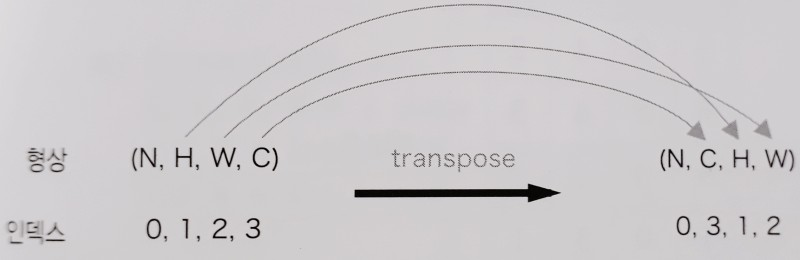

### 합성곱 계층 backward (역전파 구하기)


In [2]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [ ]:
def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


## 풀링 계층 구현하기
- im2col 사용해 입력데이터 전개
- 채널 쪽이 독립적이다. 
    - 전개한 행렬에서 행별 최댓값을 구하고 적절한 형상으로 바꾸기
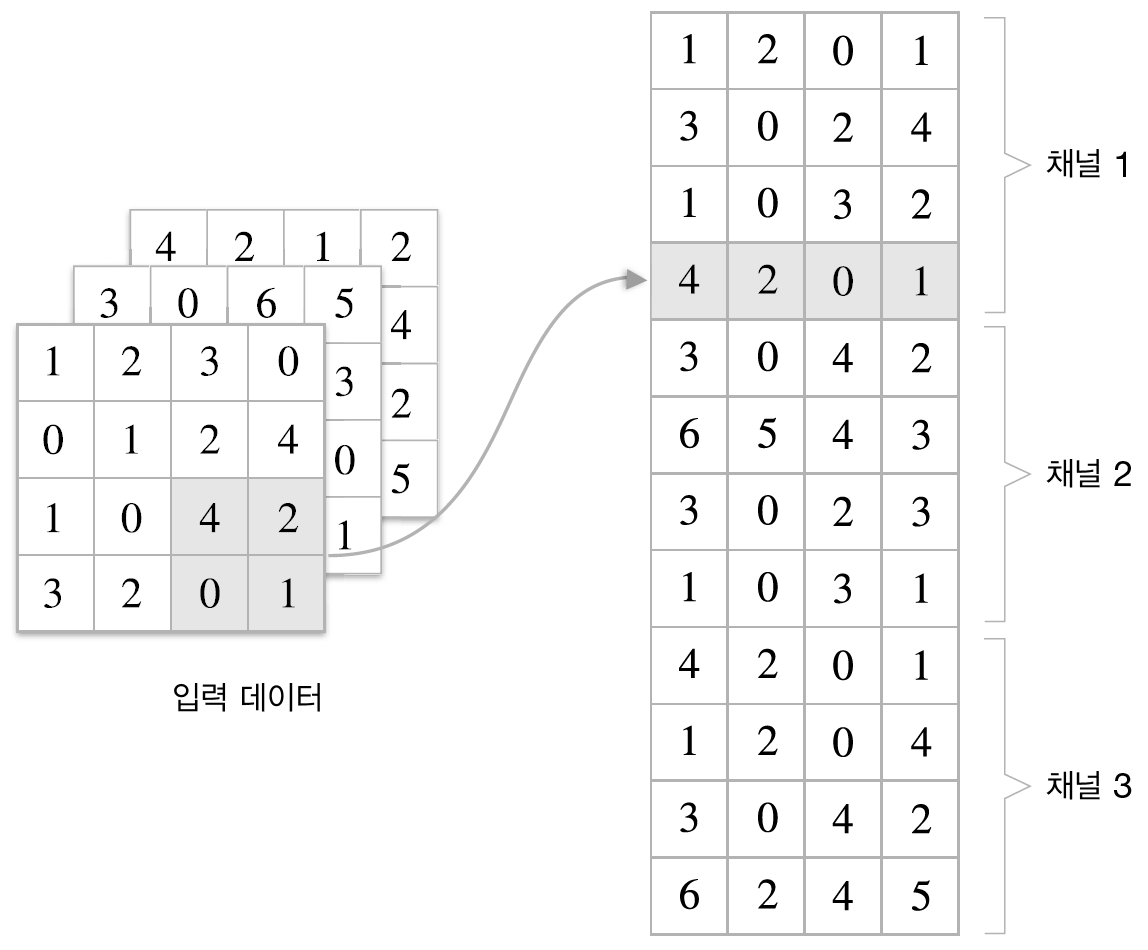

- 풀링 계층 진행 순서
    - 1. im2col로 4차원 데이터를 행렬로 (2차원) 변경한다.
    - 2. np.max를 사용하여 각 행에서의 최대값을 취한다.
    - 3. 최대값만 취한 데이터를 다시 입력 데이터의 shape으로 변경한다.

 

In [4]:

class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)     # 1) im2col 이용하여 행렬 전개
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)                                           # 2) 행별 최댓값 구하기
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)         # 3) 적절한 모양으로 reshape

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx